## **Import libraries**

In [1]:
import pandas as pd # Data Manupulation
import matplotlib.pyplot as plt # Plots
import seaborn as sns # Plots
import warnings # Ignore Warnings

In [2]:
warnings.filterwarnings("ignore") # Ignore Warnings

### **Load Data**

In [3]:
df=pd.read_csv("insurence_clear.csv")

#### *Drop Columns*

In [4]:
df=df.drop(["Unnamed: 0"],axis="columns")

###  *Split Inputs and Outputs*

In [5]:
def load_inputs_outputs():
    
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=load_inputs_outputs()

### *Split data*

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,
                                               test_size=0.33, # 33% for testing
                                               random_state=42)

In [8]:
X_train.shape[0],X_test.shape[0]

(896, 442)

#### *Data preprocessing*

**Note** Decision trees do not require normalization of their inputs; and since XGBoost is essentially an ensemble algorithm comprised of decision trees, it does not require normalization for the inputs either.

We will only perform **One Hot Encoding transformation** for categorical variable.

In [9]:
class Preprocessing_OHE():
    
    def __init__(self,X_data):
        self.X_data=X_data
    
    
    def binary(self):
        
        self.X_data["sex"]=self.X_data["sex"].apply(lambda x: 1 if x == "male"  else 0)
        self.X_data["smoker"]=self.X_data["smoker"].apply(lambda x: 1 if x == "yes"  else 0)
        
        return self.X_data
    
    def multinomial(self):
        
        return pd.get_dummies(self.X_data,columns=["region"])

   ### *Preprocessing Training Data*

In [10]:
X_train_preprocesing=Preprocessing_OHE(X_train)
X_train_ohe=X_train_preprocesing.binary()
X_train_ohe=X_train_preprocesing.multinomial()

In [11]:
X_train_ohe.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
1046,59,1,37.400,0,0,0,0,0,1
682,55,0,26.980,0,0,0,1,0,0
1037,58,0,41.910,0,0,0,0,1,0
490,41,1,28.405,1,0,0,1,0,0
39,29,0,38.830,3,0,0,0,1,0


### *Preprocessing Testing Data*

In [12]:
X_test_preprocesing=Preprocessing_OHE(X_test)
X_test_ohe=X_test_preprocesing.binary()
X_test_ohe=X_test_preprocesing.multinomial()

In [13]:
X_test_ohe.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,56,0,33.82,2,0,0,1,0,0
887,51,1,37.00,0,0,0,0,0,1
890,54,0,23.00,3,0,0,0,0,1
1293,19,0,32.49,0,1,0,1,0,0
259,22,0,27.10,0,0,0,0,0,1


##  **XGBOOST**

In [14]:
from xgboost import XGBRegressor

In [24]:
xgb_reg=XGBRegressor(max_depth=2,
                     learning_rate=0.01,
                     n_estimators=650,
                     random_state=42)

#### *Train Model*

In [25]:
xgb_reg.fit(X_train_ohe,Y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=650, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### *Model Evaluation*

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error

In [27]:
class Evaluete():
    
    def __init__(self,X_data,y_true):
            

        self.X_data=X_data
        self.y_true=y_true

        self.model=xgb_reg
        self.predict=self.model.predict(self.X_data)
    
    def mse(self):
        
        return mean_squared_error(self.y_true,self.predict)

    def r2(self):
        
        return r2_score(self.y_true,self.predict)

    def cv_score(self):
        
        return cross_val_score(self.model,self.X_data,self.y_true,cv=10).mean()


In [28]:
mse_xgb_train=Evaluete(X_train_ohe,Y_train).mse()
mse_xgb_test=Evaluete(X_test_ohe,Y_test).mse()

r2_xgb_train=Evaluete(X_train_ohe,Y_train).r2()
r2_xgb_test=Evaluete(X_test_ohe,Y_test).r2()

cv_xgb=Evaluete(X_test_ohe,Y_test).cv_score()

### *Evaluation Dataframe*

In [29]:
df_evaluate=pd.DataFrame({"MSE train ":mse_xgb_train.flatten(),
                          "MSE test":mse_xgb_test.flatten(),
                          "R2 train":r2_xgb_train.flatten(),
                          "R2 test":r2_xgb_test.flatten(),
                         "CV":cv_xgb})

In [30]:
df_evaluate

,MSE train,MSE test,R2 train,R2 test,CV
0,1.998535e+06,2.514030e+06,0.985183,0.981887,0.979176


In [39]:
sorted_idx = xgb_reg.feature_importances_.argsort()
sorted_idx=sorted_idx.flatten()

In [45]:
def plot_importance():
    
    sns.set_style(style="whitegrid")
    fig,(ax)=plt.subplots(1,1,figsize=(20,8))
    ax.set_title("Importance Features XGBBOST")
    ax.barh(X_test_ohe.columns[sorted_idx], xgb_reg.feature_importances_[sorted_idx])
    
    return plt.show()

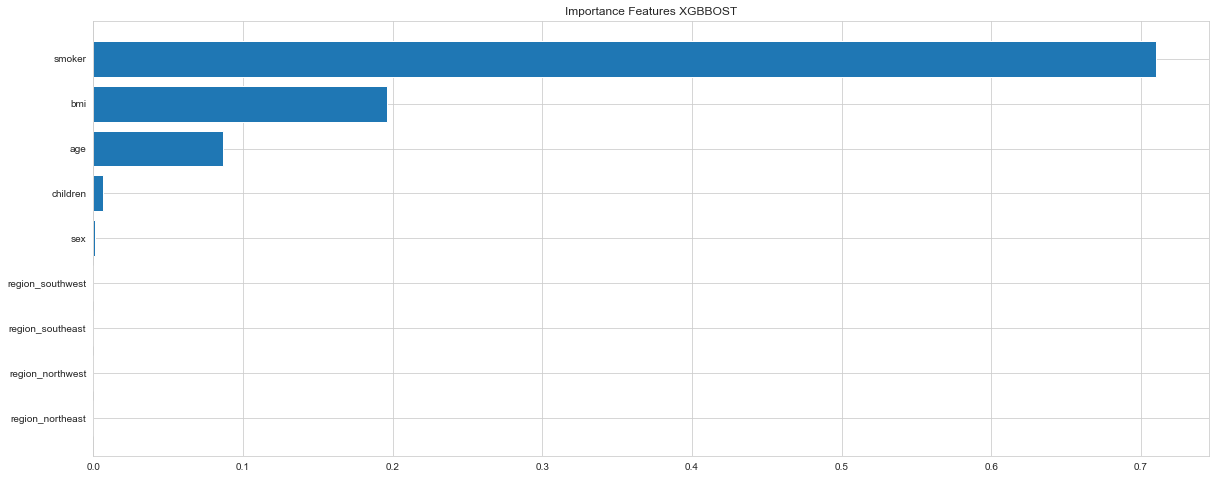

In [46]:
if __name__ == "__main__":
    plot_importance()

We observe that the smoker variable has great weight when it comes to predictions. Followed by BMI and age. The children variable has negligible weight just like the user's region.

But they complement the predictions. Since the difference between algorithms and humans. It is we humans base our predictions on features of stronger variables. On the other hand, computers base their estimates on strong variables that are not so important. But that complement the value to predict giving closer results. That only using only the most significant variables.

In [47]:
y_pred=xgb_reg.predict(X_test_ohe)
y_pred=y_pred.flatten()

In [48]:
df_test=pd.DataFrame({"y_true":Y_test,
                      "y_pred":y_pred,
                      "smoker":X_test["smoker"]})

In [55]:
def main():
    
    fig,(ax)=plt.subplots(1,1,figsize=(20,8))
    sns.scatterplot(data=df_test,x="y_true",y="y_pred",hue="smoker",palette="Set2")
    sns.lineplot(data=df_test,x="y_true",y="y_true",color="c")

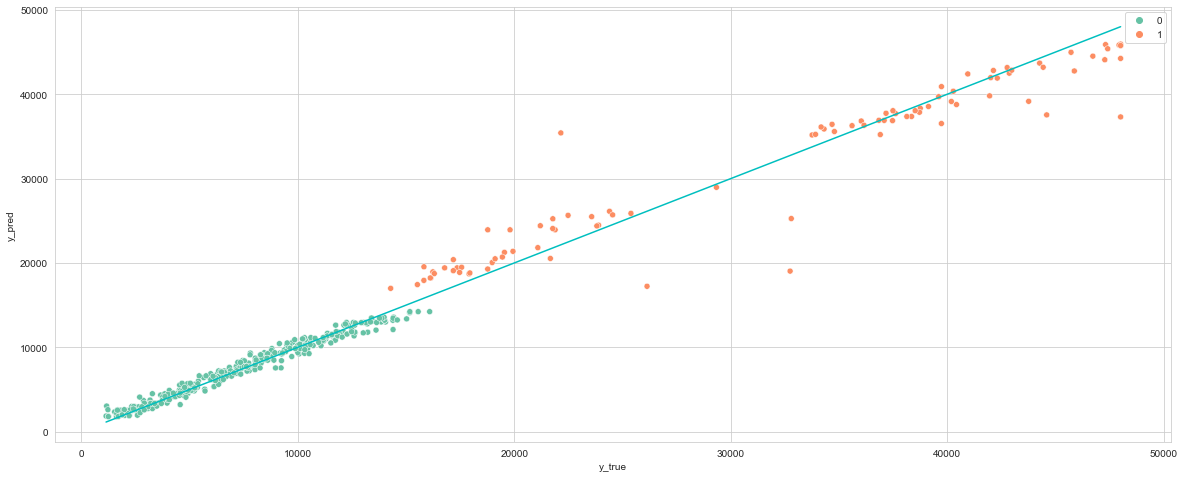

In [56]:
if __name__ == "__main__":
    
    main()

In [60]:
df_test.query("smoker==0").sample(n=10,random_state=42)

,y_true,y_pred,smoker
435,8342.908750,8693.538086,0
629,5116.500400,5577.990234,0
332,5028.146600,5741.529297,0
987,11067.917387,10184.244141,0
744,12029.286700,11362.739258,0
875,9487.644200,10311.553711,0
370,9432.925300,9477.511719,0
282,3732.625100,3691.402588,0
348,6610.109700,7017.916992,0
1055,10450.755883,9851.967773,0


In [61]:
df_test.query("smoker==1").sample(n=10,random_state=42)

,y_true,y_pred,smoker
1302,37465.34375,36863.539062,1
1127,17179.52200,20383.900391,1
1235,15817.98570,17926.035156,1
1128,42856.83800,42489.253906,1
1293,36898.73308,35210.808594,1
1122,33750.29180,35163.371094,1
1242,19798.05455,23922.166016,1
1283,33907.54800,35239.062500,1
1228,36021.01120,36820.976562,1
1078,34303.16720,35872.996094,1


As we can see, the predictions are very close to the original value. This indicates that the model is very reliable and generalizes very well. eL XGBOOST is quite a powerful algorithm, capable of giving interesting results in a short period of time. No wonder he is the winner of several Kaggle competitions.

### *Save Model*

In [62]:
import joblib

In [63]:
joblib.dump(xgb_reg,"xgb_insurence.pkl") # Save Model

['xgb_insurence.pkl']